In [1]:
import numpy as np
from numpy.linalg import norm
from numpy import random as rnd
from scipy.sparse import csr_matrix, random, hstack
from functools import partial
import time
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /Users/dmivilensky/.matplotlib because the default path (/var/folders/4w/lpt30zrj5vb3cq5mfxb3x50h0000gq/T/matplotlib-sw7qaeoq) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [161]:
n = 10_000
m = 20_000
gamma = 1

In [162]:
sparsities = rnd.exponential(scale=0.001, size=m).clip(0, 1)

In [163]:
A_ = [random(n, 1, density=sparsities[i]) * 0.01 for i in range(m)]
A = hstack(A_).T.tocsc()

In [164]:
s = max(A.getcol(k).count_nonzero() / m for k in range(n))
s

0.00185

In [165]:
L_ = [np.max(A.getcol(k).toarray() ** 2) for k in range(n)]
L = max(norm(A.getcol(k).toarray())**2 for k in range(n))

In [166]:
b = np.zeros(n)

In [167]:
def f_(x, A, b, gamma):
    mult_ = A.dot(x) / gamma
    
    # log-sum-exp trick
    c = mult_.max()
    softmax = c + np.log(np.exp(mult_ - c).sum())
    
    loss = gamma * softmax + b.dot(x)
    return loss

f = partial(f_, A=A, b=b, gamma=gamma)

In [168]:
def grad_f_(x, A, expAx, expAxSum, b, gamma, coord=-1, Acol=None):
    if coord != -1:
        grad_softmax = Acol.T.dot(expAx) / expAxSum
        grad_loss = gamma * grad_softmax + b[coord]
    else:
        grad_softmax = A.T.dot(expAx) / expAxSum
        grad_loss = gamma * grad_softmax + b
    
    return grad_loss

def stoch_grad():
    expAx = None
    expAxSum = 0
    lastAcol = None

    def stoch_grad_f(x, A, b, gamma, changed_coord=-1, get=-1, dx=None, zero_grad=False):
        nonlocal expAx, expAxSum, lastAcol
        if zero_grad:
            expAx = None
            expAxSum = 0
            lastAcol = None
            return
        
        if expAx is None or changed_coord == -1:
            expAx = np.exp(A.dot(x))
            expAxSum = expAx.sum()
        elif dx != 0:
            if rnd.random() < 0.01:
                expAx = np.exp(A.dot(x))
                expAxSum = expAx.sum()
            else:
                if lastAcol is not None:
                    r = dx[0] * lastAcol
                else:
                    r = dx[0] * A.getcol(changed_coord)
                rnz = r.nonzero()
                expAxSum -= expAx[rnz[0]].sum()
                expAx[rnz[0]] = np.exp(np.log(expAx[rnz[0]]) + r[rnz])
                expAxSum += expAx[rnz[0]].sum()
        
        lastAcol = A.getcol(get)
        loss = grad_f_(x, A, expAx, expAxSum, b, gamma, coord=get, Acol=lastAcol)
        return loss

    return stoch_grad_f

def old_(x, A, b, gamma, get=-1, changed_coord=0, dx=0):
    Ax = A.dot(x)
    expAx = np.exp(Ax)
    return grad_f_(x, A, expAx, expAx.sum(), b, gamma, coord=get, Acol=A.getcol(get))

grad_f = partial(stoch_grad(), A=A, b=b, gamma=gamma)
grad_f_old = partial(old_, A=A, b=b, gamma=gamma)

In [169]:
class FGM:
    def __init__(self, L, grad_f, x0=None):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.y = self.x.copy()
        self.L = L
        self.k = 0
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        
        prev_x = self.x.copy()
        self.x = self.y - (1/self.L) * self.grad(self.y)
        self.y = self.x + (self.k/(self.k+3)) * (self.x - prev_x)
        self.k += 1
        
        duration = time.time() - start
        return duration, self.x.copy()

In [170]:
class GM:
    def __init__(self, L, grad_f, x0=None):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.L = L
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        self.x = self.x - (1/self.L) * self.grad(self.x)
        
        duration = time.time() - start
        return duration, self.x.copy()

In [171]:
class CGM:
    def __init__(self, L_, grad_f, x0=None):
        self.last_dx = 0
        self.last_di = 0
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.L_ = L_
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        
        i = rnd.randint(n)
        dx = -(1/self.L_[i]) * self.grad(self.x, changed_coord=self.last_di, get=i, dx=self.last_dx)    
        self.x[i] = self.x[i] + dx
        
        self.last_dx = dx
        self.last_di = i
        
        duration = time.time() - start
        return duration, self.x.copy()

In [172]:
class FCGM:
    def __init__(self, L_, grad_f, x0=None):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.v = self.x.copy()
        self.L_ = L_
        self.S = np.sqrt(L_).sum()
        self.p = np.sqrt(L_) / self.S
        self.A = 0
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        
        i = rnd.choice(range(n), p=self.p)
        a = np.roots([self.S ** 2, -1, -self.A]).max()
        self.A += a
        alpha = a / self.A
        
        y = (1 - alpha) * self.x + alpha * self.v
        self.x = y.copy()
        
        grad_y = self.grad(y, get=i)
        
        self.x[i] -= (1/L_[i]) * grad_y
        self.v[i] = self.v[i] - (a*self.S/np.sqrt(L_[i])) * grad_y
        
        duration = time.time() - start
        return duration, self.x.copy()

$\psi_{x, L_h}(y) = h(x) + \langle \nabla h(x), y - x \rangle + L_h \|y - x\|_2^2 + g(y)$

In [180]:
class UM:
    def __init__(self, H, L_, grad_f, subsolver=CGM, x0=None, component=True):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.y = self.x.copy()
        self.A = 0
        self.H = H
        self.lambd = 1 / (2*H)
        self.L_inn = [(Li + H) for Li in L_]
        self.grad = grad_f
        self.subsolver = subsolver
        self.component = component
        
    def grad_Omega(self, y, x, get=-1, changed_coord=0, dx=0):
        grad_g = self.grad(y, get=get, changed_coord=changed_coord, dx=dx)
        if get == -1:
            return grad_g + self.H * (y - x)
        else:
            return grad_g + self.H * (y[get] - x[get])
    
    def step(self, t=10):
        a = (self.lambd + np.sqrt(self.lambd**2 + 4*self.lambd*self.A)) / 2
        
        x_wave = self.A/(self.A+a) * self.y + a/(self.A+a) * self.x
        if self.component:
            optimizer = self.subsolver(self.L_inn, partial(self.grad_Omega, x=x_wave), x0=self.y)
        else:
            optimizer = self.subsolver(self.H * 1.5, partial(self.grad_Omega, x=x_wave), x0=self.y)
        
        durations = np.zeros(t+1)
        ys = []
        for i in range(t):
            duration, self.y = optimizer.step()
            if i == 0:
                durations[i] = duration
            else:
                durations[i] = durations[i-1] + duration
            ys.append(self.y)
            
            if norm(self.grad_Omega(self.y, x_wave)) <= 1/8 * norm(self.grad(self.y)):
                break
            
        start = time.time()
        self.x -= a * self.grad(self.y)
        durations[i+1] = durations[i] + (time.time() - start)
        ys.append(self.y)
            
        self.A += a
        return durations[:i+2], ys

In [174]:
x0 = rnd.random(n)

In [175]:
losses_fgm = [f(x0)]
time_fgm = [0]

optimizer = FGM(L, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_fgm.append(f(x))
    time_fgm.append(time_fgm[-1] + dt)

In [176]:
losses_gm = [f(x0)]
time_gm = [0]

optimizer = GM(L, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_gm.append(f(x))
    time_gm.append(time_gm[-1] + dt)

In [177]:
losses_cgm = [f(x0)]
time_cgm = [0]

optimizer = CGM(L_, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_cgm.append(f(x))
    time_cgm.append(time_cgm[-1] + dt)

In [178]:
losses_fcgm = [f(x0)]
time_fcgm = [0]

optimizer = FCGM(L_, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_fcgm.append(f(x))
    time_fcgm.append(time_fcgm[-1] + dt)

In [181]:
losses_um = [f(x0)]
time_um = [0]

optimizer = UM(L * 0.05, L_, grad_f, subsolver=GM, x0=x0, component=False)

for _ in range(200):
    dts, xs = optimizer.step(t=1000)
    
    losses_um += [f(x) for x in xs]
    time_um += (time_um[-1] + dts).tolist()

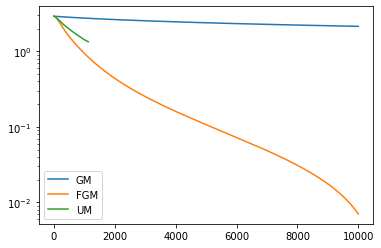

In [182]:
plt.semilogy(np.array(losses_gm) - losses_fgm[-1]*0.999, label="GM")
plt.semilogy(np.array(losses_fgm) - losses_fgm[-1]*0.999, label="FGM")
plt.semilogy(np.array(losses_um) - losses_fgm[-1]*0.999, label="UM")
plt.legend()

In [183]:
grad_f(None, zero_grad=True)

In [184]:
losses_umc = [f(x0)]
time_umc = [0]

optimizer = UM(L * 0.01, L_, grad_f, subsolver=CGM, x0=x0)

for _ in range(1000):
    dts, xs = optimizer.step(t=10)
    
    losses_umc += [f(x) for x in xs]
    time_umc += (time_umc[-1] + dts).tolist()

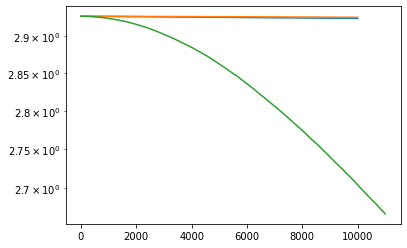

In [185]:
plt.semilogy(np.array(losses_cgm) - losses_fgm[-1]*0.999, label="CGM")
plt.semilogy(np.array(losses_fcgm) - losses_fgm[-1]*0.999, label="FCGM")
plt.semilogy(np.array(losses_umc) - losses_fgm[-1]*0.999, label="UMC")

In [189]:
f_opt = losses_gm[-1] * 0.999

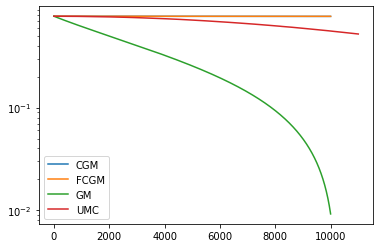

In [190]:
plt.semilogy(np.array(losses_cgm) - f_opt, label="CGM")
plt.semilogy(np.array(losses_fcgm) - f_opt, label="FCGM")
# plt.semilogy(np.array(losses_cgm)[::n][:100] - losses_fgm[-1]*0.999, label="CGM")
# plt.semilogy(np.array(losses_fcgm)[::n][:100] - losses_fgm[-1]*0.999, label="FCGM")
plt.semilogy(np.array(losses_gm) - f_opt, label="GM")
# plt.semilogy(np.array(losses_fgm) - losses_fgm[-1]*0.999, label="FGM")
plt.semilogy(np.array(losses_umc) - f_opt, label="UMC")
plt.legend()

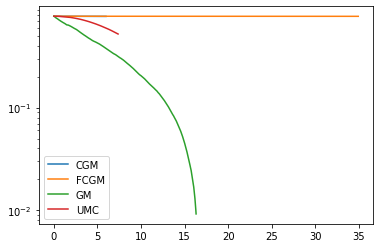

In [196]:
plt.semilogy(time_cgm, np.array(losses_cgm) - f_opt, label="CGM")
plt.semilogy(time_fcgm, np.array(losses_fcgm) - f_opt, label="FCGM")
plt.semilogy(time_gm, np.array(losses_gm) - f_opt, label="GM")
# plt.semilogy(time_fgm, np.array(losses_fgm) - f_opt, label="FGM")
plt.semilogy(time_umc, np.array(losses_umc) - f_opt, label="UMC")
plt.legend()